# PPXF vs our observation operator: are they different?

Do a data simulation using our operator, then fit with PPXF:

In [1]:
cd ../

/Users/pjethwa/Astro/Science/uq4pk


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src
from uq4pk_src.observation_operator import ObservationOperator
from ppxf import ppxf

In [3]:
ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=6000,
    lmd_max=7000,
    )
ssps.X /= np.sum(ssps.X, 0)

In [4]:
G = ObservationOperator(ssps=ssps,
                        dv=10.,
                        do_log_resample=True,
                        max_order_hermite=6)

Distribution functions should have shape (12, 53)


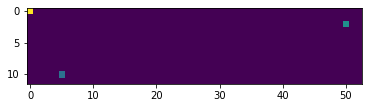

In [5]:
f_true = np.zeros((12,53))
f_true[10,5] = 1.5
f_true[0,0] = 4.
f_true[2,50] = 2.
plt.imshow(f_true)

In [6]:
theta_v_true = [100, 40, 1., 0., 0., 0.2, 0.2, 0.1, 0.3]

In [7]:
ybar = G.evaluate(f_true, theta_v_true)

In [8]:
noise = 1e-9
y = ybar + np.random.normal(scale=noise, size=ybar.size)

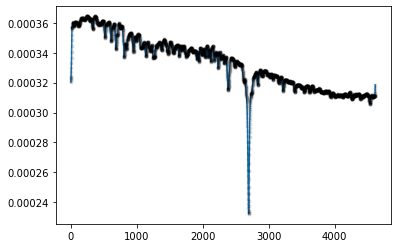

In [9]:
plt.plot(ybar)
plt.plot(y, '.k', alpha=0.1)

In [10]:
mask = np.ones_like(ybar, dtype=bool)
mask[:50] = False
mask[-50:] = False

In [ ]:
templates = ssps.Xw
galaxy = y
noise = np.ones_like(ybar)*noise
velscale = ssps.dv
start = [0., 30., 0., 0., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3], [-0.3,0.3], [-0.3,0.3]]
moments = 6
mask = mask

ppxf_fit = ppxf.ppxf(
    templates, 
    galaxy, 
    noise, 
    velscale,
    start=start,
    degree=-1,
    mdegree=-1,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask,
    bias=0       # ppxf bias for regularisation
)

In [ ]:
ppxf_fit.plot()

Let's compare the recovered distribtuion functions.

The `f` that enters our observation operator and the `weights` that come from `ppxf` differ by a factor of $\Delta t \Delta z$ i.e. the volument element of the age/metallicity grid.

To make the two comparable, we must either divide the `ppxf_fit.weights` by the volume element,

In [ ]:
delta_zt = ssps.delta_z[:, np.newaxis] * ssps.delta_t[np.newaxis, :]

In [ ]:
plt.imshow(f_true)
plt.show()

img = np.reshape(ppxf_fit.weights/delta_zt.flatten(), ssps.par_dims)
plt.imshow(img)
plt.show()

or multiply the `f` belonging to our observation operator by the volume element, i.e.

In [ ]:
plt.imshow(f_true*delta_zt)
plt.show()

img = np.reshape(ppxf_fit.weights, ssps.par_dims)
plt.imshow(img)
plt.show()

This second choice should make our result comparable to `m54_data.ppxf_map_solution`.

Let's compare the kinematics,

In [ ]:
print(theta_v_true)

In [ ]:
ppxf_fit.sol

There is a sign differnce in the odd gauss hermite moments.